# **Занятие 5. Классификация изображений**

https://vk.com/lambda_brain

Классификация изображений -- это уже полноценная задача реального мира. Самое приятное здесь в том, что нету качественного алгоритмического отличия классификации изображений от классификации других наборов данных. Нейронные сети работают таким магическим образом, что мы просто подаём им на вход наборы "байтов", и не важно, что это -- абстрактные значения функций или пикселы изображений, они все анализируются нейросетью по единой схеме.

Мы познакомимся с основными принципами классификации изображений в PyTorch, а также изучим смежные вопросы, связанные с загрузкой объёмных датасетов с изображениями в программу и их удобной визуализацией.


# MNIST



---


В качестве первого примера воспользуемся распространённым датасетом изображений **MNIST**, на котором создано наверное максимальное количество обучающих уроков по нейронным сетям.

MNIST подготовлен **Яном ЛеКуном** -- ведущим мировым специалистом по нейронным сетям, и представляет собой датасет для обучения распознаванию рукописных цифр. Обучающая выборка содержит 60,000 изображений, и тестовая -- 10,000. Каждое изображение чёрно-белое размером 28x28 пикселов.

Импортируем нужные модули:


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms


Задаём гипер-параметры:

In [2]:

input_size = 28*28     # Размер изображения в точках
hidden_size = 500      # Количество нейронов в скрытом слое
num_classes = 10       # Количество распознающихся классов (10 цифр)
n_epochs = 2           # Количество эпох
batch_size = 4         # Размер мини-пакета входных данных
lr = 0.01              # Скорость обучения

Большое количество готовых датасетов и различные удобные методы их загрузки и обработки собраны в модуле torchvision. Имеется в нём конечно и MNIST.

В конструкторе датасета MNIST указывается, как правило, каталог root, где будет локально размещён соответствующий датасет, download -- необходимость скачивания датасета для его локального использования, train -- признак, является ли данный датасет обучающим или тестовым, и трансформация transform, которую надо выполнить над данным датасетом. Последняя фича весьма полезна, потому что исходные изображения нередко требуется предварительно обрабатывать под конкретный формат их дальнейшего анализа. В нашем случае просто укажем стандартную трансформацию преобразования входных данных в тензоры.

Убедимся, что размеры датасета совпадают с официально объявленными.


In [3]:
import torchvision.transforms as transforms
mnist_trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


Так как наш датасет большой по размеру, обрабатывать его надо небольшими порциями, мини-пакетами, как рассказывалось во втором занятии -- с помощью загрузчиков данных DataLoader.

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                           batch_size=batch_size,
                                           shuffle=True) # загрузчик обучающих данных
test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=batch_size,
                                          shuffle=False) # загрузчик тестовых данных

Добавим наш стандартный шаг обучения.

In [5]:
# импортируем нужные библиотеки
import torch
import numpy as np # всегда пригодится :)
from torch.nn import Linear, Sigmoid

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# добавляем типовую функцию "шаг обучения"
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

Структура нашей модели будет представлять собой двуслойную нейронную сеть -- она ничем не отличается от модели, применявшейся в прошлом занятии при анализе абстрактного датасета (линейный вход + ReLU + линейный выход).

Воспользуемся лоссом CrossEntropyLoss() и методом оптимизации Adam.

Обратите внимание, что мы задаём уже не тысячи, а **всего две эпохи** -- процесс обучения на таком довольно объёмном датасете потребует уже прилично времени (несколько минут на одну эпоху).

Единственное дополнение -- мы применяем метод reshape(-1, 28 * 28), чтобы изменить входной трёхмерный формат изображения 1x28x28 (глубина цветности x размеры) на нужный нам одномерный вектор длиной 784 значения. Параметр -1 означает, что преобразование выполняется в одномерный результат.


In [6]:
from torch import optim, nn

model = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes))
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
    print(f"{epoch=} {loss=}")

# print(model.state_dict())
print(loss)

epoch=0 loss=0.46270567178726196
epoch=1 loss=0.008376606740057468
0.008376606740057468


Теперь проверим, с какой точностью наша модель проверит 10,000 тестовых изображений:

In [7]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 91.7 %


Около 90% -- это очень хороший результат для тренировки всего в течение пяти минут за две эпохи. Обратите внимание, что обученная модель время на распознавание даже такого приличного по объёму датасета уже практически не тратит.


---



Вычисление, конечно, может занимать не минуты, а часы, сутки, недели и месяцы работы. Чтобы продолжить работу с нашей обученной моделью уже в прикладных задачах, нам надо прежде всего её сохранить в файле (в PyTorch принято, что расширение файла с полностью сохранённой моделью -- .pt).


In [8]:
torch.save(model, 'mnist_full.pt')

Сохранение выполняется в виртуальной машине гугла, где мы загрузили датасет MNIST. Загрузка модели выполняется так же просто:

In [9]:
model = torch.load("mnist_full.pt")
model.eval()

/tmp/ipykernel_42693/86338239.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("mnist_full.pt")


Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=10, bias=True)
)

После загрузки модели надо обязательно выполнить её метод **eval()** -- это означает, что мы будем пользоваться моделью в режиме её эксплуатации, а не в режимах обучения или каких-то других.

##**Задание**

Попробуйте повысить точность нашей модели:

* увеличьте количество эпох;
* увеличьте количество нейронов;
* добавьте новые скрытые слои;
* измените размер мини-пакета.


---

* При желании придумайте, как визуализировать работу модели на тестовых данных (показывать изображения и соответствующий им распознанный класс).





Далее мы рассмотрим работу с более сложным датасетом изображений (котики и пёсики), которому потребуется предварительная обработка.

In [10]:
input_size = 28*28     # Размер изображения в точках
hidden_size = 1024     # Количество нейронов в скрытом слое
num_classes = 10       # Количество распознающихся классов (10 цифр)
n_epochs = 20          # Количество эпох
batch_size = 1024      # Размер мини-пакета входных данных
lr = 0.01              # Скорость обучения

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                           batch_size=batch_size,
                                           shuffle=True) # загрузчик обучающих данных
test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=batch_size,
                                          shuffle=False) # загрузчик тестовых данных

In [12]:
from torch import optim, nn

model = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size // 2),
    nn.ReLU(),
    nn.Linear(hidden_size // 2, hidden_size // 4),
    nn.ReLU(),
    nn.Linear(hidden_size // 4, hidden_size // 8),
    nn.ReLU(),
    nn.Linear(hidden_size // 8, hidden_size // 16),
    nn.ReLU(),
    nn.Linear(hidden_size // 16, num_classes)
)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=10, bias=True)
)


In [13]:
for epoch in range(n_epochs):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
    print(f"{epoch=} {loss=}")

print(loss)

epoch=0 loss=0.2686638832092285
epoch=1 loss=0.12298985570669174
epoch=2 loss=0.08585553616285324
epoch=3 loss=0.09001269191503525
epoch=4 loss=0.03509070351719856
epoch=5 loss=0.09281663596630096
epoch=6 loss=0.03161889314651489
epoch=7 loss=0.021360861137509346
epoch=8 loss=0.033233970403671265
epoch=9 loss=0.04020183905959129
epoch=10 loss=0.016224684193730354
epoch=11 loss=0.02644667774438858
epoch=12 loss=0.02096288837492466
epoch=13 loss=0.05634865537285805
epoch=14 loss=0.020939920097589493
epoch=15 loss=0.03144346550107002
epoch=16 loss=0.06292232871055603
epoch=17 loss=0.01832468807697296
epoch=18 loss=0.0442609004676342
epoch=19 loss=0.022074095904827118
0.022074095904827118


In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Точность: {} %'.format(100 * correct / total))

Точность: 97.95 %


In [15]:
import matplotlib.pyplot as plt

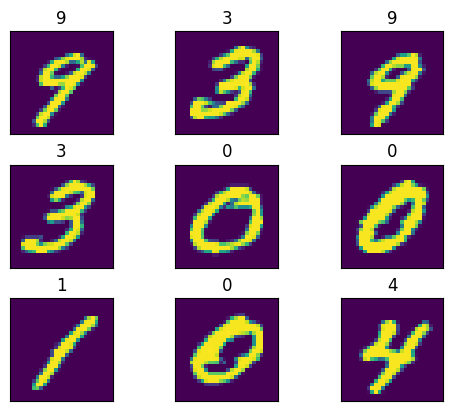

In [16]:
f, axarr = plt.subplots(3,3)
plt.subplots_adjust(wspace=0, hspace=0.3)
for i in range(9):
    axarr[i//3, i%3].imshow(images[i].cpu().reshape(28, 28, 1), label="123")
    axarr[i//3, i%3].set_title(predicted[i].item())
    axarr[i//3, i%3].tick_params(
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )
plt.show()

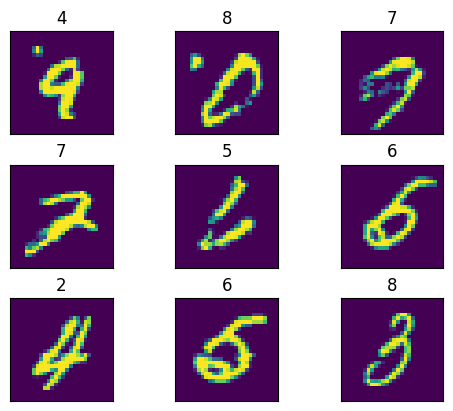

In [17]:
incorrects = [i for i in range(28*28) if (predicted!=labels)[i]][:9]

f, axarr = plt.subplots(3,3)
plt.subplots_adjust(wspace=0, hspace=0.3)
for i in range(9):
    j = incorrects[i]
    axarr[i//3, i%3].imshow(images[j].cpu().reshape(28, 28, 1), label="123")
    axarr[i//3, i%3].set_title(predicted[j].item())
    axarr[i//3, i%3].tick_params(
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )
plt.show()